In [2]:
!pip install reportlab

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
sns.set(style='whitegrid')

# File path
file_path = 'Summer-Olympic-medals-1976-to-2008.csv'

# Try utf-8 first, fallback to latin1
try:
    df = pd.read_csv(file_path)
except Exception as e:
    print('UTF-8 load failed, trying latin1...')
    df = pd.read_csv(file_path, encoding='latin1')

print('Dataset loaded. Shape:', df.shape)
df.head()

UTF-8 load failed, trying latin1...
Dataset loaded. Shape: (15433, 11)


,City,Year,Sport,Discipline,Event,Athlete,Gender,Country_Code,Country,Event_gender,Medal
0,Montreal,1976.0,Aquatics,Diving,3m springboard,"KÖHLER, Christa",Women,GDR,East Germany,W,Silver
1,Montreal,1976.0,Aquatics,Diving,3m springboard,"KOSENKOV, Aleksandr",Men,URS,Soviet Union,M,Bronze
2,Montreal,1976.0,Aquatics,Diving,3m springboard,"BOGGS, Philip George",Men,USA,United States,M,Gold
3,Montreal,1976.0,Aquatics,Diving,3m springboard,"CAGNOTTO, Giorgio Franco",Men,ITA,Italy,M,Silver
4,Montreal,1976.0,Aquatics,Diving,10m platform,"WILSON, Deborah Keplar",Women,USA,United States,W,Bronze


In [5]:
# Inspect columns & basic info
print(df.columns.tolist())
print('\nInfo:')
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

['City', 'Year', 'Sport', 'Discipline', 'Event', 'Athlete', 'Gender', 'Country_Code', 'Country', 'Event_gender', 'Medal']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15433 entries, 0 to 15432
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          15316 non-null  object 
 1   Year          15316 non-null  float64
 2   Sport         15316 non-null  object 
 3   Discipline    15316 non-null  object 
 4   Event         15316 non-null  object 
 5   Athlete       15316 non-null  object 
 6   Gender        15316 non-null  object 
 7   Country_Code  15316 non-null  object 
 8   Country       15316 non-null  object 
 9   Event_gender  15316 non-null  object 
 10  Medal         15316 non-null  object 
dtypes: float64(1), object(10)
memory usage: 1.3+ MB
None

Missing values per column:
City            117
Year            117
Sport           117
Discipline      117
Event           117
Athlete         1

In [6]:
# Standardize column names: lowercase, strip, replace spaces
df.columns = [c.strip().replace(' ', '_').lower() for c in df.columns]
print(df.columns.tolist())

# Year to numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')
# Drop rows missing essential fields
essential = ['year','sport','event','athlete','gender','country','medal']
df = df.dropna(subset=essential)
print('After dropping missing essential fields:', df.shape)

# Remove duplicates
df = df.drop_duplicates()
print('After dropping duplicates:', df.shape)

str_cols = df.select_dtypes(include='object').columns
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()

df.head()

['city', 'year', 'sport', 'discipline', 'event', 'athlete', 'gender', 'country_code', 'country', 'event_gender', 'medal']
After dropping missing essential fields: (15316, 11)
After dropping duplicates: (15315, 11)


,city,year,sport,discipline,event,athlete,gender,country_code,country,event_gender,medal
0,Montreal,1976.0,Aquatics,Diving,3m springboard,"KÖHLER, Christa",Women,GDR,East Germany,W,Silver
1,Montreal,1976.0,Aquatics,Diving,3m springboard,"KOSENKOV, Aleksandr",Men,URS,Soviet Union,M,Bronze
2,Montreal,1976.0,Aquatics,Diving,3m springboard,"BOGGS, Philip George",Men,USA,United States,M,Gold
3,Montreal,1976.0,Aquatics,Diving,3m springboard,"CAGNOTTO, Giorgio Franco",Men,ITA,Italy,M,Silver
4,Montreal,1976.0,Aquatics,Diving,10m platform,"WILSON, Deborah Keplar",Women,USA,United States,W,Bronze


In [7]:
print('Years range:', df['year'].min(), '-', df['year'].max())
print('\nMedal counts:')
print(df['medal'].value_counts())
print('\nGender counts:')
print(df['gender'].value_counts())
print('\nTop countries by medals:')
print(df['country'].value_counts().head(10))

Years range: 1976.0 - 2008.0

Medal counts:
medal
Bronze    5258
Gold      5041
Silver    5016
Name: count, dtype: int64

Gender counts:
gender
Men      9387
Women    5928
Name: count, dtype: int64

Top countries by medals:
country
United States     1992
Soviet Union      1021
Australia          798
Germany            691
China              679
Russia             638
East Germany       626
Italy              486
Romania            482
United Kingdom     467
Name: count, dtype: int64


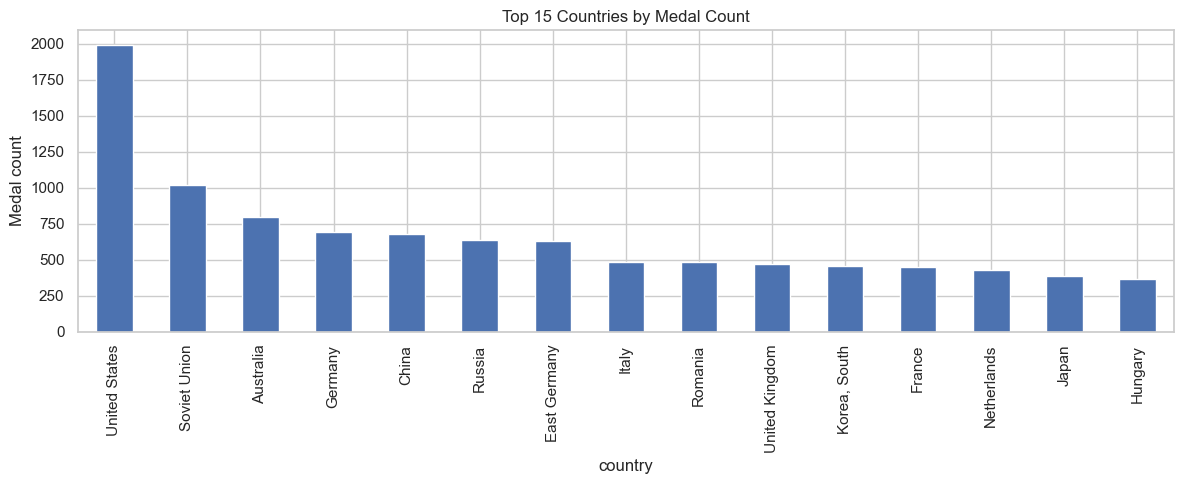

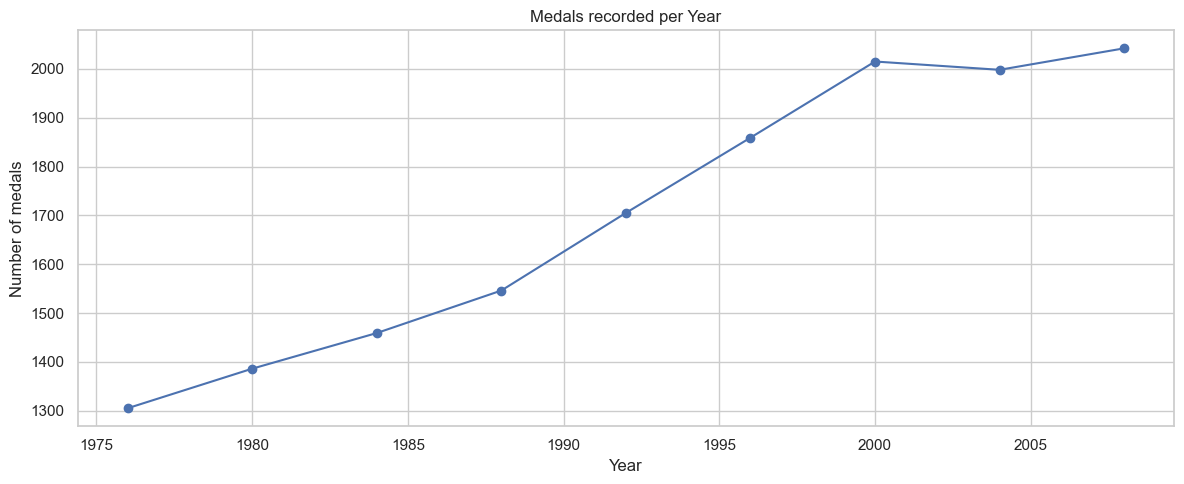

In [8]:
import matplotlib.ticker as mtick

plt.figure(figsize=(12,5))
# Top 15 countries
top_countries = df['country'].value_counts().head(15)
top_countries.plot(kind='bar')
plt.title('Top 15 Countries by Medal Count')
plt.ylabel('Medal count')
plt.tight_layout()
plt.show()

# Medals per year
plt.figure(figsize=(12,5))
medals_per_year = df.groupby('year').size()
plt.plot(medals_per_year.index, medals_per_year.values, marker='o')
plt.title('Medals recorded per Year')
plt.xlabel('Year')
plt.ylabel('Number of medals')
plt.grid(True)
plt.tight_layout()
plt.show()

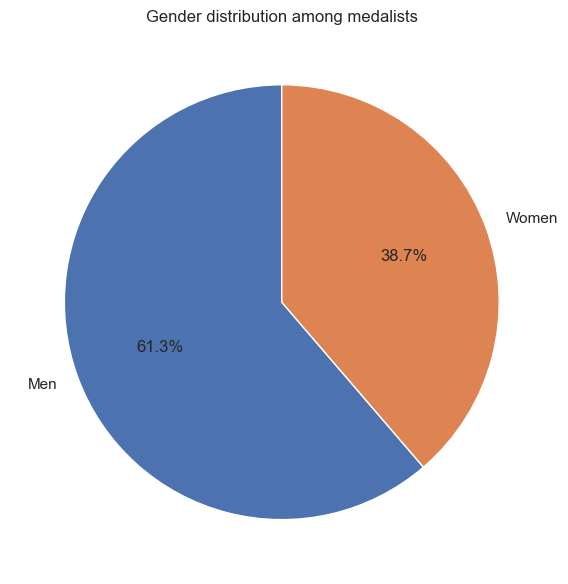

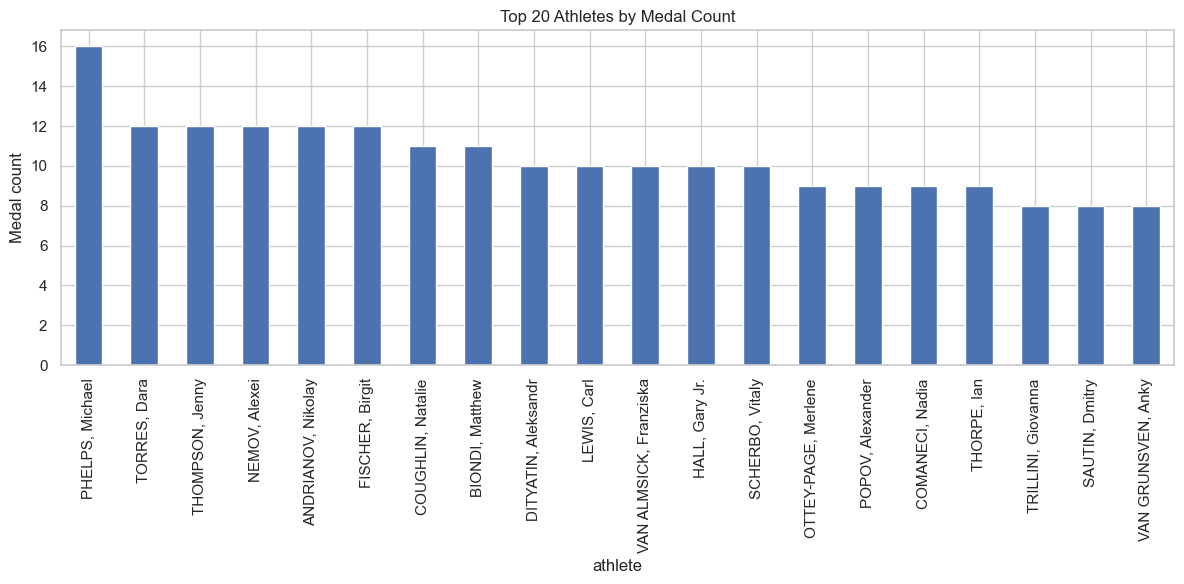

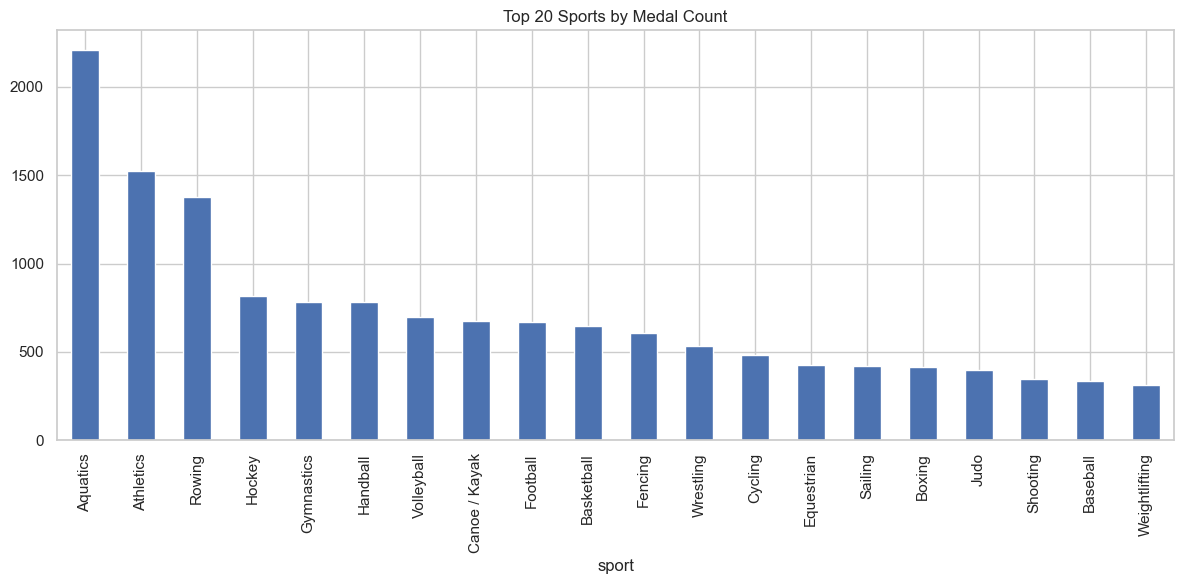

In [9]:
# Gender distribution
plt.figure(figsize=(6,6))
df['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Gender distribution among medalists')
plt.tight_layout()
plt.show()

# Top athletes
plt.figure(figsize=(12,6))
top_ath = df['athlete'].value_counts().head(20)
top_ath.plot(kind='bar')
plt.title('Top 20 Athletes by Medal Count')
plt.ylabel('Medal count')
plt.tight_layout()
plt.show()

# Sport distribution (top 20)
plt.figure(figsize=(12,6))
df['sport'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Sports by Medal Count')
plt.tight_layout()
plt.show()

In [10]:
# Pivot examples
# Medals by country and year (top 10 countries)
countries = df['country'].value_counts().head(10).index.tolist()
pivot_cy = df[df['country'].isin(countries)].pivot_table(index='year', columns='country', values='medal', aggfunc='count').fillna(0)
print(pivot_cy.head())

# Medals by sport and gender
pivot_sg = df.pivot_table(index='sport', columns='gender', values='medal', aggfunc='count').fillna(0)
print(pivot_sg.sort_values(by=pivot_sg.columns.tolist(), ascending=False).head())

country  Australia  China  East Germany  Germany  Italy  Romania  Russia  \
year                                                                       
1976.0        24.0    0.0         192.0      0.0   31.0     55.0     0.0   
1980.0        12.0    0.0         260.0      0.0   37.0     72.0     0.0   
1984.0        50.0   76.0           0.0      0.0   63.0    106.0     0.0   
1988.0        34.0   53.0         174.0      0.0   29.0     51.0     0.0   
1992.0        57.0   83.0           0.0    198.0   46.0     53.0     0.0   

country  Soviet Union  United Kingdom  United States  
year                                                  
1976.0          285.0            32.0          155.0  
1980.0          442.0            45.0            0.0  
1984.0            0.0            72.0          333.0  
1988.0          294.0            53.0          193.0  
1992.0            0.0            50.0          224.0  
gender            Men   Women
sport                        
Aquatics       1156.0 

Training Random Forest...
Done.
              precision    recall  f1-score   support

      Bronze       0.70      0.70      0.70      1052
        Gold       0.68      0.73      0.70      1008
      Silver       0.68      0.63      0.65      1003

    accuracy                           0.68      3063
   macro avg       0.68      0.68      0.68      3063
weighted avg       0.68      0.68      0.68      3063



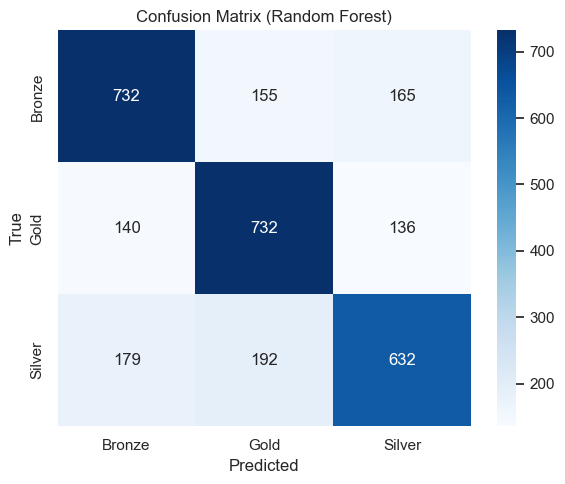

In [13]:
# Preprocessor: impute year and one-hot encode categoricals
cat_feats = ['country','sport','gender']
num_feats = ['year']

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
])

# Random Forest pipeline
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

print('Training Random Forest...')
pipe_rf.fit(X_train, y_train)
print('Done.')

# Evaluate
y_pred = pipe_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le_medal.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_medal.classes_, yticklabels=le_medal.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.show()
